In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit

pd.set_option("display.max_columns", 50)

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

# Get the data

In [2]:
%run get_data.py
benchmarks = ('adpcm_encoder', 'average', 'fir')
gd = GetData('data/ES', benchmarks, load_fpga_v5=False)
gd.main()
gd.data_v4.keys()

dict_keys(['adpcm_encoder', 'average', 'fir'])

# Data analysis

In [3]:
%run methods.py

## Direct Mapping

adpcm_encoder


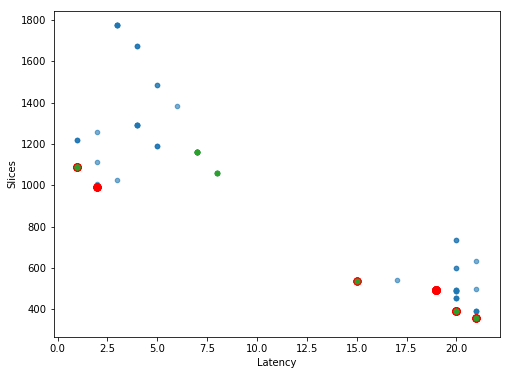

The accurate Pareto set
[[  15  536]
 [  19  493]
 [   2  992]
 [  21  356]
 [  20  392]
 [   1 1089]]
The predicted Pareto set
[[  15  536]
 [  21  356]
 [  20  392]
 [   7 1160]
 [   1 1089]
 [   8 1060]]
adrs_ave: 0.02506897283531409
adrs_max: 0.09778225806451613
adrs_ave_rms: 0.026057874556347293
adrs_max_rms: 0.08753267684958413
hypervolume: 0.27220855398845356
dominance: 0.6666666666666666
cardinality: 6
average


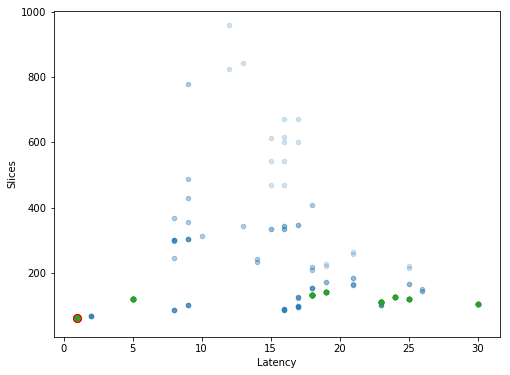

The accurate Pareto set
[[ 1 60]]
The predicted Pareto set
[[ 18 131]
 [ 24 125]
 [ 25 120]
 [ 30 104]
 [ 19 140]
 [ 23 111]
 [  1  60]
 [  5 119]]
adrs_ave: 0.0
adrs_max: 0.0
adrs_ave_rms: 0.0
adrs_max_rms: 0.0
hypervolume: 0.4526181511763195
dominance: 1.0
cardinality: 8
fir


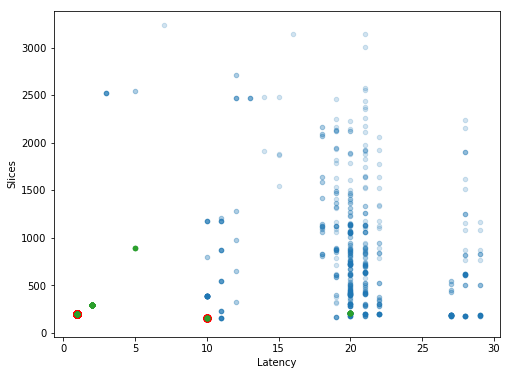

The accurate Pareto set
[[ 10 153]
 [  1 199]]
The predicted Pareto set
[[  1 199]
 [  2 296]
 [ 10 153]
 [  5 891]
 [ 20 206]]
adrs_ave: 0.0
adrs_max: 0.0
adrs_ave_rms: 0.0
adrs_max_rms: 0.0
hypervolume: 0.3377235497291035
dominance: 1.0
cardinality: 5


In [4]:
results_direct_mapping = {}
for i in benchmarks:
    print(i)
    results_direct_mapping[i] = DirectMapping.main(gd.data_v4[i], plot_figure=True, display_table=True)
    print_results(results_direct_mapping[i])
    print('=' * 40)

## Hands-On ML Chapter 2

In [5]:
def pre_processing(data_set):
    X = data_set.drop(['Slices', 'Latency'], axis=1)
    y = data_set['Slices'].copy()
    print('Features')
    display(X.head(2))
    print('Labels')
    display(y.head(2))
    # feature scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    print('After scaling')
    print(X)
    return X, y

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [11]:
def train_one_benchmark(data):
    # split data
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(data, data['Latency']):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    # pre-processing
    X, y = pre_processing(train_set)
    
    title = 'Learning Curve (Linear Regression)'
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    estimator = LinearRegression()
    plot_learning_curve(estimator, title, X, y, ylim=(0.9, 1.01), cv=cv, n_jobs=4)
    plt.show()

In [7]:
features = ['AREA', 'state', 'FU', 'REG', 'MUX', 'DEC', 'pin_pair',
            'net', 'max', 'min', 'ave', 'MISC', 'MEM', 'sim', 'Pmax',
            'Pmin', 'Pave', 'Latency', 'BlockMemoryBit', 'DSP', 'Slices']
# 'CP_delay',

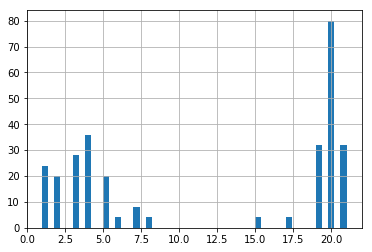

In [9]:
benchmark_training = 'adpcm_encoder'

data_train = gd.data_v4[benchmark_training]
data_train['Latency'].hist(bins=50)
plt.show()

In [10]:
data_train = data_train[features]
data_train.info()
# replace non-numeric value with 0
data_train = data_train.replace(regex=[r'-', r'0'], value=0)
data_train.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 299
Data columns (total 21 columns):
AREA              296 non-null int64
state             296 non-null int64
FU                296 non-null int64
REG               296 non-null int64
MUX               296 non-null int64
DEC               296 non-null int64
pin_pair          296 non-null int64
net               296 non-null int64
max               296 non-null int64
min               296 non-null int64
ave               296 non-null float64
MISC              296 non-null int64
MEM               296 non-null object
sim               296 non-null object
Pmax              296 non-null object
Pmin              296 non-null object
Pave              296 non-null object
Latency           296 non-null int64
BlockMemoryBit    296 non-null object
DSP               296 non-null object
Slices            296 non-null int64
dtypes: float64(1), int64(13), object(7)
memory usage: 50.9+ KB


,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices
0,1839,3,670,642,501,0,3588,1621,3,3,3.0,26,0,0,0,0,0,20,0,0,456
1,2035,2,900,624,489,0,3905,1793,2,2,2.0,22,0,0,0,0,0,19,0,0,493
2,2035,2,900,624,489,0,3905,1793,2,2,2.0,22,0,0,0,0,0,19,0,0,493


Features


,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,BlockMemoryBit,DSP
46,4304,3,2748,666,849,0,9552,4366,3,3,3.0,41,0,0,0,0,0,0,0
244,5512,2,4233,624,625,0,11619,5334,2,2,2.0,30,0,0,0,0,0,0,0


Labels


46     1484
244    1773
Name: Slices, dtype: int64

After scaling
[[ 0.88 -0.16  0.53 ...,  0.    0.    0.  ]
 [ 1.81 -0.5   1.67 ...,  0.    0.    0.  ]
 [ 0.95 -0.84  1.15 ...,  0.    0.    0.  ]
 ..., 
 [-0.93  3.91 -1.12 ...,  0.    0.    0.  ]
 [-0.66  1.53 -0.79 ...,  0.    0.    0.  ]
 [-0.79 -0.16 -0.83 ...,  0.    0.    0.  ]]


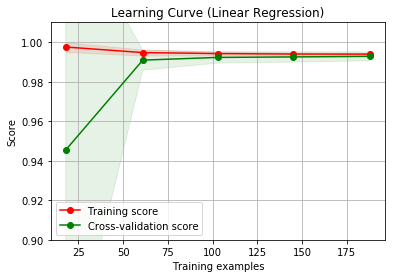

Wall time: 3.83 s


In [13]:
%%time
train_one_benchmark(data_train)

## Plot learning curve

In [ ]:
%%time
title = 'Learning Curve (Linear Regression)'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.9, 1.01), cv=cv, n_jobs=4)
plt.show()

In [ ]:
# split data
split = StratifiedShuffleSplit(n_splits=1, test_size=100, random_state=42)
for train_index, test_index in split.split(data_train, data_train['Latency']):
    X = data_train.iloc[train_index]

In [ ]:
X.head(2)

In [ ]:
X, y = pre_processing(X)

In [ ]:
X_test, y_test = pre_processing(data_train)

In [ ]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X_test)
data_pred = data_train.copy()
data_pred['AREA'] = y_pred
DirectMapping.main(data_pred, plot_figure=True)

In [ ]:
data_train = gd.data_v4['average'][features].replace(regex=[r'-', r'0'], value=0)
X_test, y_test = pre_processing(data_train)

y_pred = model.predict(X_test)
data_pred = data_train.copy()
data_pred['AREA'] = y_pred
DirectMapping.main(data_pred, plot_figure=True)

In [ ]:
data_train = gd.data_v4['fir'][features].replace(regex=[r'-', r'0'], value=0)
X_test, y_test = pre_processing(data_train)

y_pred = model.predict(X_test)
data_pred = data_train.copy()
data_pred['AREA'] = y_pred
DirectMapping.main(data_pred, plot_figure=True)

In [ ]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5)
scores

In [ ]:
# select and train a model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
measure_rmse(lin_reg, X_train_prepared, y_train)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)
measure_rmse(tree_reg, X_train_prepared, y_train)

In [ ]:
scores_cv = measure_cv(lin_reg, X_train_prepared, y_train)

In [ ]:
scores_cv = measure_cv(tree_reg, X_train_prepared, y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
scores_cv = measure_cv(forest_reg, X_train_prepared, y_train)

In [ ]:
forest_reg.fit(X_train_prepared, y_train)
measure_rmse(forest_reg, X_train_prepared, y_train)
# forest_reg.feature_importances_

In [ ]:
# fine tune the model
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train_prepared, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
measure_rmse(grid_search.best_estimator_, X_train_prepared, y_train)

In [ ]:
model = train_one_benchmark(data_train)

In [ ]:
# testing
X_test = strat_test_set[features].copy()
y_test = strat_test_set['Slices'].copy()

In [ ]:
X_test_prepared = scaler.fit_transform(X_test)

In [ ]:
measure_rmse(model, X_test_prepared, y_test)

In [ ]:
X_test = data_v4['adpcm_encoder'][features].copy()
y_test = data_v4['adpcm_encoder']['Slices'].copy()

In [ ]:
X_test_prepared = scaler.fit_transform(X_test)

In [ ]:
print(y_test.median())
print(measure_rmse(forest_reg, X_test_prepared, y_test))

In [ ]:
# feature selection: recursive feature elimination
# https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
rfe = RFE(model, 4)
rfe = rfe.fit(X_v4_scaled['adpcm_encoder'], y_v4['adpcm_encoder'])

In [ ]:
rfe.support_

In [ ]:
rfe.ranking_

In [ ]:
# feature selection: feature importance
model.feature_importances_

In [ ]:
corr_matrix = train_set.corr()
corr_with_slices = corr_matrix['Slices'].sort_values(ascending=False)
corr_with_slices